### NON-LLM Based

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [2]:
class QuadState(TypedDict):
    
    a: int
    b: int
    c: int

    equation: str
    discriminant: float
    result: str

In [3]:
def show_equation(state: QuadState):

    equation = f"{state['a']}x² + {state['b']}x + {state['c']} = 0"

    return {'equation': equation}


def calculate_discriminant(state: QuadState):

    discriminant = state['b'] ** 2 - 4 * state['a'] * state['c']
    return {'discriminant': discriminant}


def real_roots(state: QuadState):
    
    root1 = (-state['b'] + state['discriminant'] ** 0.5) / (2 * state['a'])
    root2 = (-state['b'] - state['discriminant'] ** 0.5) / (2 * state['a'])
    result = f"Real roots: {root1}, {root2}"

    return {'result': result}

def repeated_roots(state: QuadState):
    
    root = -state['b'] / (2 * state['a'])
    result = f"Repeated root: {root}"

    return {'result': result}

def no_real_roots(state: QuadState):
    
    result = f"No real roots"

    return {'result': result}


In [4]:
#to create condition inside workflow

def check_condition(state: QuadState):

    if state['discriminant'] > 0:
        return 'real_roots'
    elif state['discriminant'] == 0:
        return 'repeated_roots'
    else:
        return 'no_real_roots'

In [5]:
graph = StateGraph(QuadState)

In [6]:
graph.add_node('show_equation', show_equation)
graph.add_node('calculate_discriminant', calculate_discriminant)
graph.add_node('real_roots', real_roots)
graph.add_node('no_real_roots', no_real_roots)
graph.add_node('repeated_roots', repeated_roots)

graph.add_edge(START, 'show_equation')
graph.add_edge('show_equation', 'calculate_discriminant')

graph.add_conditional_edges('calculate_discriminant', check_condition)

graph.add_edge('real_roots', END)
graph.add_edge('repeated_roots', END)
graph.add_edge('no_real_roots', END)

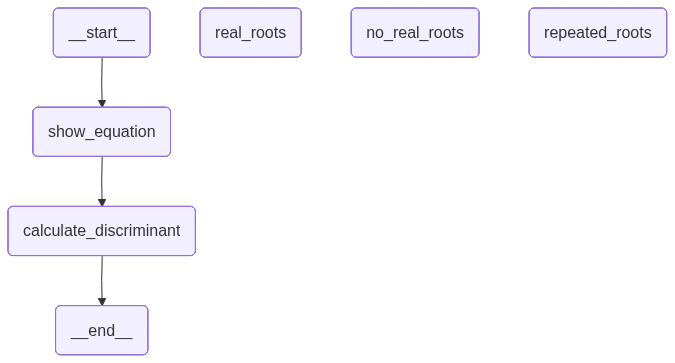

In [7]:
graph.compile()

In [8]:
workflow = graph.compile()

In [9]:
initial_state = { 'a': 1, 'b': -3, 'c': 2 }
final_state = workflow.invoke(initial_state)

In [10]:
final_state

{'a': 1,
 'b': -3,
 'c': 2,
 'equation': '1x² + -3x + 2 = 0',
 'discriminant': 1,
 'result': 'Real roots: 2.0, 1.0'}

### NON-LLM Based

In [11]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field


In [12]:
load_dotenv()

True

In [13]:
import os
GROK_API_KEY = os.getenv("GROK_API_KEY")

In [14]:
model = ChatGroq(api_key=GROK_API_KEY, model="llama-3.1-8b-instant")

In [15]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negative', 'neutral'] = Field(description="The sentiment of the text")

In [16]:
structured_model = model.with_structured_output(SentimentSchema)

In [17]:
prompt = "Do I Love programming!"
result = structured_model.invoke(prompt)
result

SentimentSchema(sentiment='positive')

In [18]:
result.sentiment

'positive'

In [19]:
#now creating our real workflow

In [20]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal['positive', 'negative', 'neutral']
    diagnosis: dict
    response: str

In [21]:
class DiagnosisSchema(BaseModel):
    
    issues: Literal['angry','sad','disappointed','weird'] = Field(description="Issues found in the review and how it appears")
    suggestions: list[str] = Field(description="List of suggestions to improve the review")

In [22]:
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [23]:
def find_Sentiment(state: ReviewState):

    prompt = f"Determine the sentiment of the following review: {state['review']}"

    structured_model = model.with_structured_output(SentimentSchema)

    result = structured_model.invoke(prompt).sentiment

    return {'sentiment': result}


def check_sentiment(state: ReviewState):

    if state['sentiment'] == 'positive':
        return 'positive_diagnosis'
    elif state['sentiment'] == 'negative':
        return 'negative_diagnosis'
    else:
        return 'neutral_diagnosis'


def positive_response(state: ReviewState):

    prompt = f"The review is positive: {state['review']}. Provide a detailed analysis of why the review is positive."

    response = model.invoke(prompt).content

    return{'response': response}

def negative_response(state: ReviewState): 

    prompt = f"The review is negative: {state['diagnosis']['tone']}. Provide a detailed analysis of why the review is negative."

    response = model.invoke(prompt).content

    return{'response': response}

def neutral_response(state: ReviewState):

    prompt = f"The review is neutral: {state['review']}. Provide a detailed analysis of why the review is neutral."

    response = model.invoke(prompt).content

    return{'response': response}


def run_diagnosis(state: ReviewState): #here now we need structured output so here also we have to define schema for it

    prompt = f"Based on the following diagnosis: {state['review']}, return tone and  suggest improvements for the review."

    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

In [26]:
graph = StateGraph(ReviewState)

graph.add_node('find_Sentiment', find_Sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('negative_response', negative_response)
graph.add_node('neutral_response', neutral_response)

graph.add_edge(START, 'find_Sentiment')

graph.add_conditional_edges('find_Sentiment', check_sentiment)

graph.add_node('positive_response', END)
graph.add_edge('neutral_response', END)

graph.add_node('run_diagnosis', 'negative_response')
graph.add_edge('negative_diagnosis', END)


ValueError: Node `positive_response` already present.

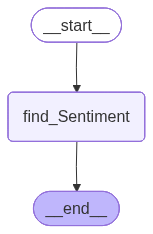

In [49]:
graph.compile()

In [50]:
workflow = graph.compile()

In [51]:
initial_state = { 'review': "I love programming!" }
final_state = workflow.invoke(initial_state)
final_state

{'review': 'I love programming!', 'sentiment': 'positive'}